In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")  # Adjusts the path to include the parent directory

from rps_simulation.rps_base import RPS_core  # Importing RPS_core class from rps_base.py
from rps_simulation.rps_multirun import RPS_multirun # Importing RPS_Multirun class, used for main plots

from rps_simulation.learning_curves import exponential_learning, logistic_learning # learonning curves
from rps_simulation.forgetting_curves import exponential_forgetting  # forgetting curves
from rps_simulation.practice_rate import simple_linear_rate  # simple linear rate
from rps_simulation.waiting_times import exponential_waiting_time  # exp waiting time distributi


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

# Colour codes for concave and sigmoid curves:
concave_colour = '#466be8'
sigmoid_colour = '#f77150'

plot_dpi = 300 #dpi at which plots will be saved


np.random.seed(10) #setting seed for reproducible results 


## 1. Individual Differences in Learning rate $\alpha$:



In [25]:
n_agents = 1000 # Number of learners in the simulation

# parameters varied:
alphas = np.random.uniform(low=0.4, high=0.8, size=n_agents) # learning rates
skill_maxs = np.random.uniform(low=0.5, high=1, size=n_agents) # Maximum skill levels

# Constant parameters:
betas = np.repeat(0.2, n_agents) # forgetting rates
ass = np.repeat(0.2, n_agents) # min. practice rates
bs = np.repeat(5, n_agents) # success sensitivity
S0s = np.repeat(0.1, n_agents) # initial skills 
prac_rate0s = np.repeat(0.1, n_agents) # Initial practice rates


# lists for saving data:
S_finals = [] # final skills
PE_tots = [] # total practice events
S_at_quit = [] # skill at quitting time

for i in range(n_agents):
    LC_log = logistic_learning(alpha=alphas[i], skill_max=skill_maxs[i]) # learning curve
    F_exp = exponential_forgetting(betas[i]) # forgetting curve 
    PR_simple = simple_linear_rate(a=ass[i], b=bs[i]) # practice rate

    # Simulate learning of agent i: 
    model_ = RPS_core(learning_func=LC_log,
                      forgetting_func=F_exp,
                      practice_rate_func=PR_simple,
                      waiting_time_dist=exponential_waiting_time,
                      initial_skill=S0s[i],
                      initial_practice_rate=prac_rate0s[i],
                      max_time=100)
    
    model_.run_simulation()


    # Store sim data:
    S_finals.append(model_.final_skill)
    PE_tots.append(model_.total_practice_events)  
    S_at_quit.append(model_.skill_levels[-2])  


    

# Make dataframe:
df_ID_alpha = pd.DataFrame({'S_finals': S_finals, 
                            'PE_tots':PE_tots, 
                            'S_at_quit': S_at_quit})



Now plotting:

In [26]:
def logis(x):
    out = 1/(1 + np.exp(-x))
    return out

def log_odds(p):
    out = np.log(p/(1-p))
    return out


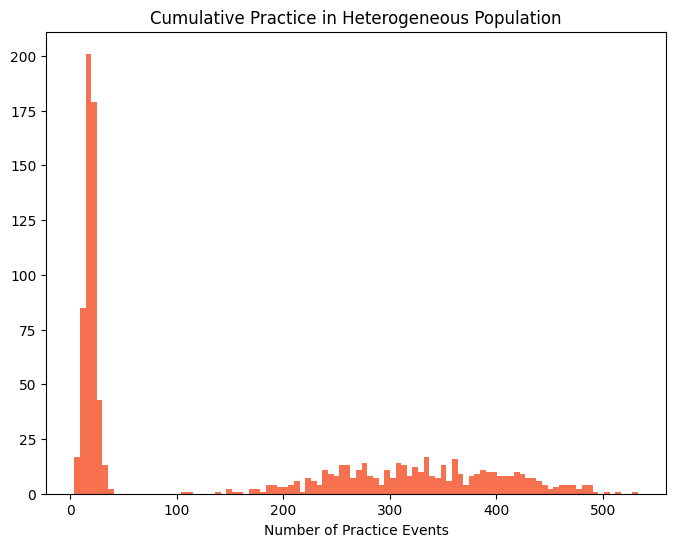

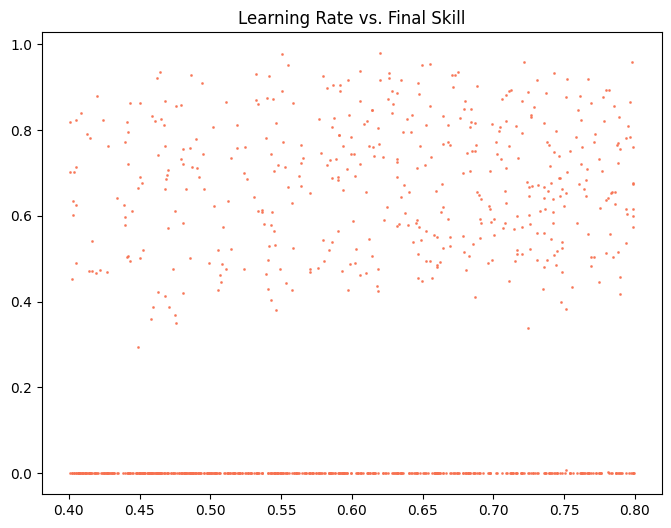

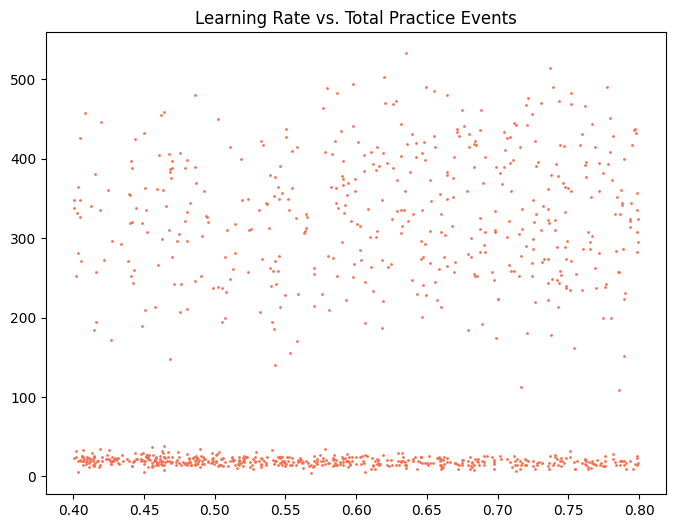

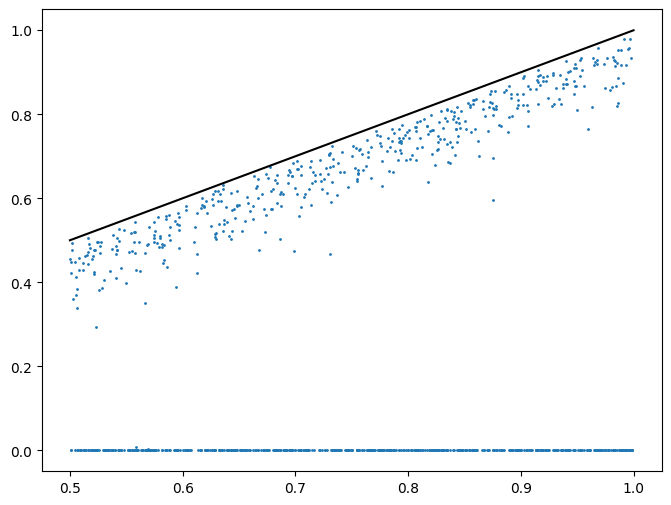

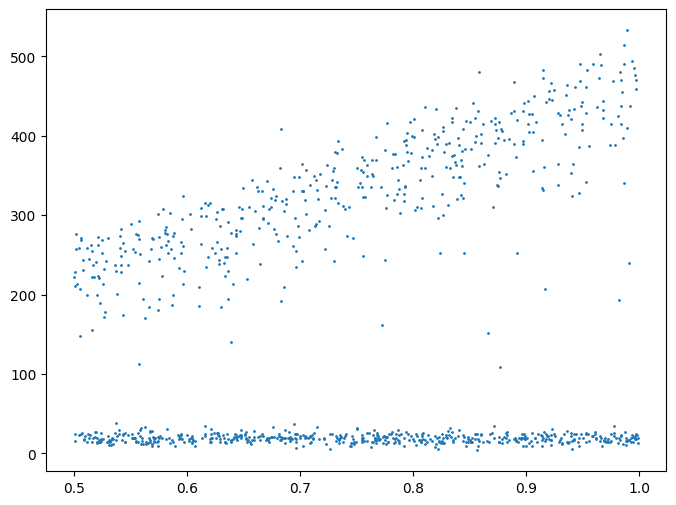

In [ ]:
dotsize=1

# Histogram of total practice events:
plt.figure(figsize=(8,6))
plt.hist(np.array(PE_tots), bins=100, color=sigmoid_colour, alpha=1)
plt.title('Cumulative Practice in Heterogeneous Population')
plt.xlabel('Number of Practice Events')
plt.show()



# ---- Effect of individual diffs. in learning rate ----
# Learning rate vs. Final Skill
plt.figure(figsize=(8, 6))
plt.scatter(alphas, S_finals, s=dotsize, color=sigmoid_colour, alpha=0.8)
plt.title('Learning Rate vs. Final Skill')
plt.show()


# Learning rate vs. Total Practice Events
plt.figure(figsize=(8, 6))
plt.scatter(alphas, PE_tots, s=dotsize, color=sigmoid_colour, alpha=1)
plt.title('Learning Rate vs. Total Practice Events')
plt.show()


# ----- Effect of individual diffs. in S_max ------- 
# S_max vs. Final Skill
plt.figure(figsize=(8, 6))
plt.scatter(skill_maxs, S_finals, s=dotsize)
plt.plot([0.5, 1], [0.5, 1], color='black')
plt.show()

# S_max vs. Tot. Practice Events
plt.figure(figsize=(8, 6))
plt.scatter(skill_maxs, PE_tots, s=dotsize)
plt.show()



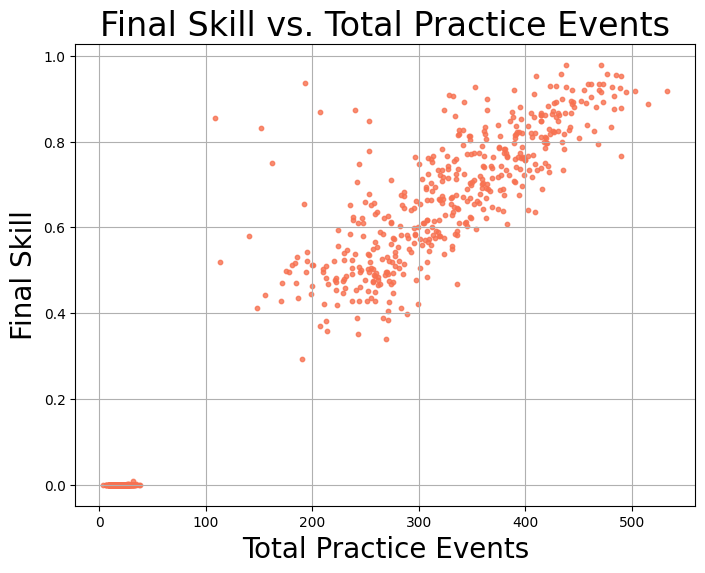

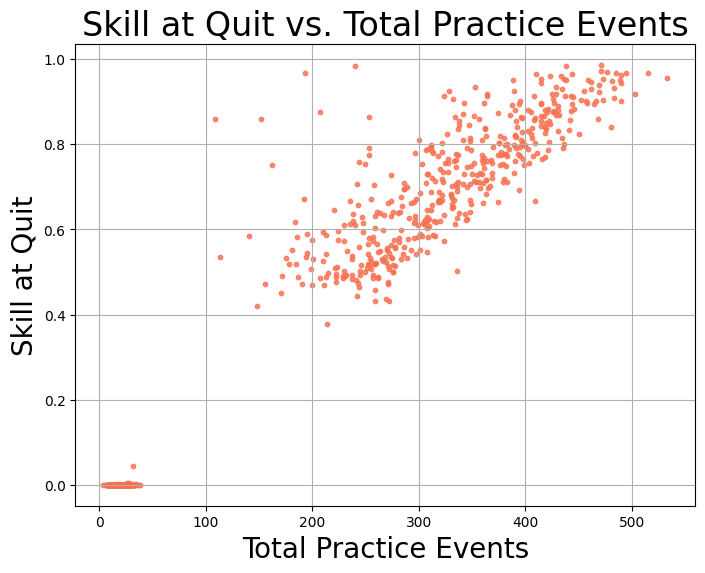

In [32]:


## --- Add 2D density plot ------
# ---- on second thoughts, doesn't look good, bad x-axis with -ve values ----
# plt.figure(figsize=(8, 6))
# sns.kdeplot(
#     data=df_ID_alpha, x="S_finals", y="PE_tots", 
#     fill=True, levels=100
#     #cmap='seagreen'
# )
# plt.show()

## --- scatter plot - final skill vs. total practice events ------
plt.figure(figsize=(8, 6))  
plt.scatter(df_ID_alpha['PE_tots'], df_ID_alpha['S_finals'], 
            s=10, color=sigmoid_colour, alpha=0.8)
plt.title('Final Skill vs. Total Practice Events', fontsize=24)
plt.ylabel('Final Skill', fontsize=20)
plt.xlabel('Total Practice Events', fontsize=20)
#plt.xlim(0, 1)
#plt.ylim(0, 100)
plt.grid(True)
plt.savefig('../plots/ID_Sf_vs_Ptot.jpg', dpi=plot_dpi, bbox_inches='tight')
plt.show()



## --- scatter plot - Skill at quit vs. total practice events ------
plt.figure(figsize=(8, 6))  
plt.scatter(df_ID_alpha['PE_tots'], df_ID_alpha['S_at_quit'], 
            s=10, color=sigmoid_colour, alpha=0.8)
plt.title('Skill at Quit vs. Total Practice Events', fontsize=24)
plt.ylabel('Skill at Quit', fontsize=20)
plt.xlabel('Total Practice Events', fontsize=20)
#plt.xlim(0, 1)
#plt.ylim(0, 100)
plt.grid(True)
plt.savefig('../plots/ID_SQuit_vs_Ptot.jpg', dpi=plot_dpi, bbox_inches='tight')
plt.show()

 

## 2. Smooth Plots:

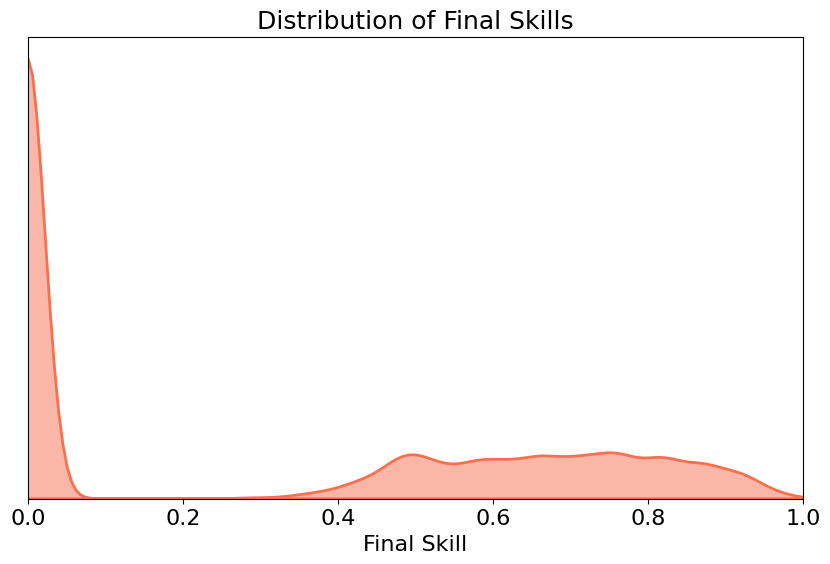

In [33]:
plt.figure(figsize=(10, 6))

# Create the distribution plot
sns.kdeplot(
    data=df_ID_alpha['S_finals'],
    color=sigmoid_colour,
    fill=True,
    alpha=0.5,
    linewidth=2,
    #bw_adjust=bw_adjust
    bw_adjust=0.25
)


# tick-params:
plt.tick_params(left = True, right = False , labelleft = True)
plt.xticks(fontsize=16)
plt.xlim([0,1])
plt.yticks([], fontsize=16)
plt.ylabel('', fontsize=16)
plt.xlabel('Final Skill', fontsize=16)
plt.title('Distribution of Final Skills', fontsize=18)

plt.savefig('../plots/ID_alpha_final_skills.jpg', dpi=plot_dpi, bbox_inches='tight')
plt.show()


# Add a rug plot at the bottom for data points
# sns.rugplot(
#     data=df_ID_alpha['S_finals'],
#     color=sigmoid_colour,
#     alpha=0.5,
#     height=0.05
# )


# if save_location != False:
#     plt.savefig(save_location, dpi=save_dpi, bbbox_inches='tight')
#     plt.show()


## 3. Han's Plot:

In [34]:


df_ID_alpha['log-Skill'] = log_odds(df_ID_alpha['S_finals'])
df_ID_alpha.head()

,S_finals,PE_tots,S_at_quit,log-Skill
0,0.000002,21,0.000007,-13.008766
1,0.468742,215,0.497830,-0.125195
2,0.579265,248,0.592984,0.319756
3,0.000003,26,0.000006,-12.796230
4,0.506198,255,0.506900,0.024795


In [35]:
# Function to create PE_tots bins
def create_pe_bins(df, n_bins=5):
    """
    Create equal-sized bins for PE_tots values
    """
    # Create bins using pd.cut
    df_copy = df.copy()
    df_copy['PE_tots_binned'] = pd.cut(df_copy['PE_tots'], 
                                       bins=n_bins, 
                                       include_lowest=True,
                                       precision=0)
    
    # Create readable labels for the bins
    bin_labels = []
    for interval in df_copy['PE_tots_binned'].cat.categories:
        left = int(interval.left)
        right = int(interval.right)
        bin_labels.append(f"{left}-{right}")
    
    # Replace the interval objects with string labels
    df_copy['PE_tots_bin_label'] = df_copy['PE_tots_binned'].astype(str)
    for i, interval in enumerate(df_copy['PE_tots_binned'].cat.categories):
        df_copy.loc[df_copy['PE_tots_binned'] == interval, 'PE_tots_bin_label'] = bin_labels[i]
    
    return df_copy

# Method 2: Overlaid density plots for all bins
def plot_overlaid_density_bins(df, n_bins=5, figsize=(10, 6)):
    """
    Create overlaid density plots for all PE_tots bins on single plot
    """
    # Create binned data
    df_binned = create_pe_bins(df, n_bins)
    
    plt.figure(figsize=figsize)
    
    # Get unique bins and sort them
    unique_bins = df_binned['PE_tots_bin_label'].unique()
    unique_bins = sorted(unique_bins, key=lambda x: int(x.split('-')[0]))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_bins)))
    
    for i, bin_label in enumerate(unique_bins):
        bin_data = df_binned[df_binned['PE_tots_bin_label'] == bin_label]['S_finals']
        sns.kdeplot(data=bin_data, label=f'PE_tots: {bin_label}', 
                   color=colors[i], fill=True, alpha=0.3)
    
    plt.xlabel('S_final (Final Skill)')
    plt.ylabel('Density')
    plt.title('Distribution of Final Skill by Practice Total (Binned)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Method 3: Histogram version with bins
def plot_histograms_by_bins(df, n_bins=5, hist_bins=30, figsize=(12, 8)):
    """
    Create histogram plots grouped by PE_tots bins
    """
    # Create binned data
    df_binned = create_pe_bins(df, n_bins)
    
    # Get unique bins and sort them
    unique_bins = df_binned['PE_tots_bin_label'].unique()
    unique_bins = sorted(unique_bins, key=lambda x: int(x.split('-')[0]))
    
    # Create subplots
    n_rows = int(np.ceil(n_bins / 2))
    fig, axes = plt.subplots(n_rows, 2, figsize=figsize, sharex=True)
    if n_bins <= 2:
        axes = [axes] if n_bins == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, bin_label in enumerate(unique_bins):
        ax = axes[i] if n_bins > 1 else axes
        
        # Filter data for current bin
        bin_data = df_binned[df_binned['PE_tots_bin_label'] == bin_label]['S_finals']
        
        # Create histogram
        ax.hist(bin_data, bins=hist_bins, alpha=0.7, color='gray', 
               density=True, edgecolor='black', linewidth=0.5)
        
        # Customize subplot
        ax.set_title(f'PE_tots: {bin_label}', fontsize=12)
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    if n_bins > 1:
        for j in range(len(unique_bins), len(axes)):
            axes[j].set_visible(False)
    
    plt.xlabel('S_final (Final Skill)')
    plt.suptitle('Histogram of Final Skill by Practice Total (Binned)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Method 4: Seaborn FacetGrid with binned data
def plot_facetgrid_density_bins(df, n_bins=5):
    """
    Use seaborn FacetGrid to create density plots with binned PE_tots
    """
    # Create binned data
    df_binned = create_pe_bins(df, n_bins)
    
    # Create a FacetGrid
    g = sns.FacetGrid(df_binned, col='PE_tots_bin_label', col_wrap=2, 
                      height=4, aspect=1.2)
    
    # Map the density plot to each facet
    g.map(sns.kdeplot, 'S_final', fill=True, alpha=0.7, color='gray')
    
    # Customize
    g.set_axis_labels('S_final (Final Skill)', 'Density')
    g.set_titles('PE_tots: {col_name}')
    
    # Add grid to each subplot
    for ax in g.axes.flatten():
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Distribution of Final Skill by Practice Total (Binned)', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Quick one-liner using seaborn displot with binned data
def quick_plot_bins(df, n_bins=5):
    """
    Quick plot using seaborn displot with binned PE_tots
    """
    df_binned = create_pe_bins(df, n_bins)
    
    sns.displot(data=df_binned, x='S_finals', col='PE_tots_bin_label', 
                kind='kde', fill=True, col_wrap=2, height=4, aspect=1.2)
    plt.suptitle('Distribution of Final Skill by Practice Total (Binned)', y=1.02)
    plt.show()


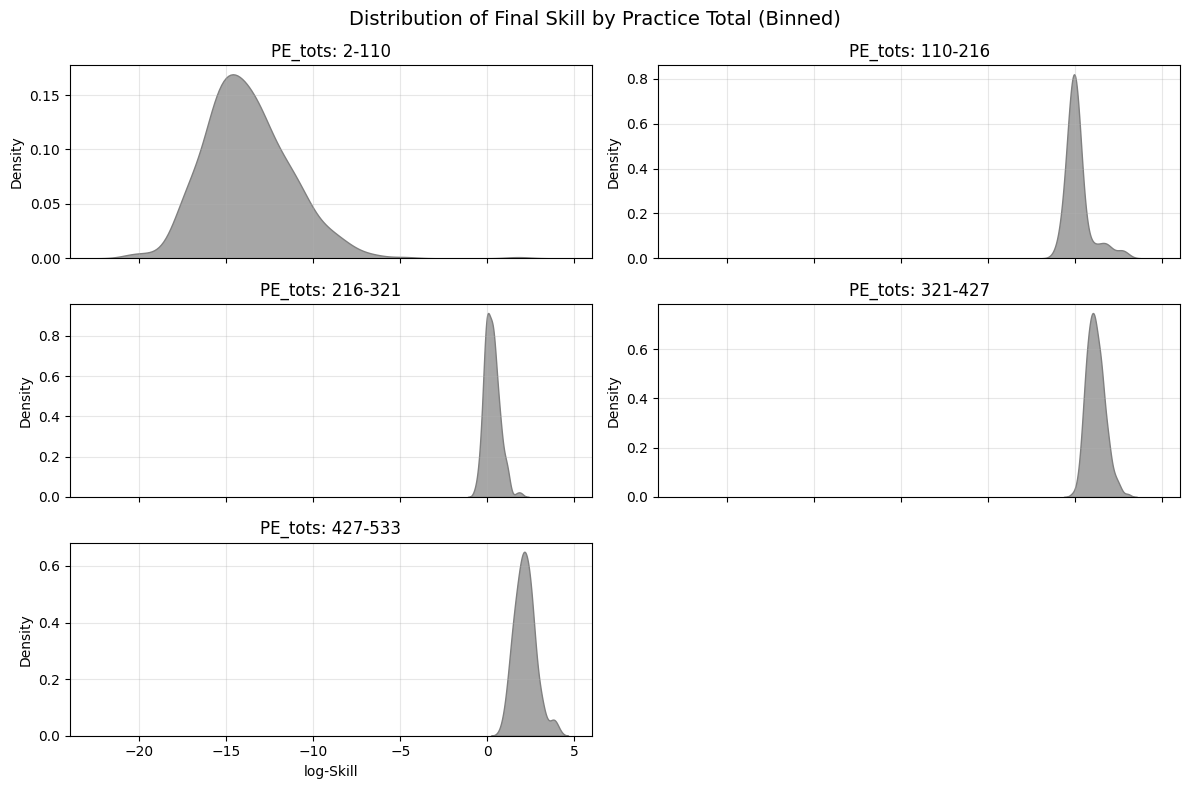

In [36]:

# Method 1: Smoothed Density Plots (KDE) with binned PE_tots
def plot_density_by_bins(df, n_bins=5, figsize=(12, 8)):
    """
    Create density plots grouped by PE_tots bins, similar to the R ridgeline plot
    """
    # Create binned data
    df_binned = create_pe_bins(df, n_bins)
    
    # Get unique bins and sort them
    unique_bins = df_binned['PE_tots_bin_label'].unique()
    # Sort by the lower bound of each bin
    unique_bins = sorted(unique_bins, key=lambda x: int(x.split('-')[0]))
    
    # Create subplots
    n_rows = int(np.ceil(n_bins / 2))
    fig, axes = plt.subplots(n_rows, 2, figsize=figsize, sharex=True)
    if n_bins <= 2:
        axes = [axes] if n_bins == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, bin_label in enumerate(unique_bins):
        ax = axes[i] if n_bins > 1 else axes
        
        # Filter data for current bin
        bin_data = df_binned[df_binned['PE_tots_bin_label'] == bin_label]['log-Skill']
        
        # Create KDE plot
        sns.kdeplot(data=bin_data, ax=ax, fill=True, alpha=0.7, color='gray')
        
        # Customize subplot
        ax.set_title(f'PE_tots: {bin_label}', fontsize=12)
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    if n_bins > 1:
        for j in range(len(unique_bins), len(axes)):
            axes[j].set_visible(False)
    
    plt.xlabel('S_final (Final Skill)')
    plt.suptitle('Distribution of Final Skill by Practice Total (Binned)', fontsize=14)
    plt.tight_layout()
    plt.show()



plot_density_by_bins(df_ID_alpha, n_bins=5)